In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from models.encodetocontact import DLEM
import torch
from util import train_w_signal

In [2]:
dev = torch.device('cuda')

In [3]:
def plot_corr(mat):
    seaborn.heatmap(np.corrcoef(mat))

In [4]:
def plot_map_diff(map1, map2, signal1d1, signal1d2, start, stop, axes=None):
    if axes is None:
        _, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8.5),
                               sharex='col',
                               sharey='row',
                               gridspec_kw={'wspace':0,
                                           'hspace':0,
                                           'height_ratios':[1,2]})
    map1 = map1[start:stop, start:stop]
    map2 = map2[start:stop, start:stop]
    signal1d1 = signal1d1[start:stop]
    signal1d2 = signal1d2[start:stop]
    for i, map in enumerate([map1, map2, np.abs(map1 - map2)]):
        axes[1,i].matshow(map, cmap="icefire")
        axes[1,i].xaxis.set_ticks_position('bottom')
        axes[1,i].xaxis.set_label_position('bottom')
    for i, s in enumerate([signal1d1, signal1d2, np.hstack([signal1d1, signal1d2])]):
        axes[0,i].plot(s)

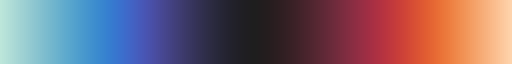

In [5]:
seaborn.color_palette("icefire", as_cmap=True)

In [6]:
chromosome = "chr10"
start = 13600000
stop = 14400000
resolution = 8000
start_binned = start//resolution
stop_binned = stop//resolution

In [7]:
map_h1 = np.load(".data/ForGrant/chr10_8k_H1.npy")[:-1, :-1]
map_hff = np.load(".data/ForGrant/chr10_8k_HFF.npy")[:-1, :-1]

In [8]:
map_h1[np.isnan(map_h1)] = 0
map_hff[np.isnan(map_hff)] = 0

In [9]:
encode = pd.read_csv(".data/ForGrant/OutBinned.txt", sep="\t")

In [10]:
encode

,#Chromosome,Start,End,MeanSignal_H1_DNAse_ENCFF232GUZ.bigWig,MeanSignal_H1_ENCFF038RVZ_CTCF-human.bigWig,MeanSignal_H1_ENCFF380KPI_H3K27me3-human.bigWig,MeanSignal_H1_ENCFF396RXV_H3K4me1-human.bigWig,MeanSignal_H1_ENCFF760NUN_H3K4me3-human.bigWig,MeanSignal_H1_ENCFF919FBG_H3K27ac-human.bigWig,MeanSignal_HFF_CTCF_ENCFF406SZM.bigWig,MeanSignal_HFF_DNAse_ENCFF498YIW.bigWig,MeanSignal_HFF_ENCFF076GOF_CTCF-human.bigWig,MeanSignal_HFF_ENCFF402LWA_H3K27me3-human.bigWig,MeanSignal_HFF_ENCFF451EDD_H3K4me1-human.bigWig,MeanSignal_HFF_ENCFF509UMN_H3K27ac-human.bigWig,MeanSignal_HFF_ENCFF752EUQ_H3K4me3-human.bigWig
0,chr1,0,8000,0.000000,0.000000,0.000000,0.000000,0.000458,0.002921,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,chr1,8000,16000,0.024312,0.045100,0.000000,0.009062,0.011814,0.034310,0.110720,0.013918,0.019876,0.079271,0.099012,0.203324,0.023013
2,chr1,16000,24000,0.005070,0.081177,0.000000,0.034436,0.010160,0.009176,0.220085,0.003063,0.155866,0.058723,0.097079,0.121236,0.000000
3,chr1,24000,32000,0.001026,0.000000,0.023164,0.000000,0.015801,0.000000,0.000000,0.000992,0.000000,0.007297,0.003515,0.011253,0.026793
4,chr1,32000,40000,0.000316,0.000000,0.000000,0.000000,0.002258,0.000000,0.002757,0.000242,0.009527,0.013642,0.015946,0.002179,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360210,chr9_KI270719v1_random,168000,176000,0.000000,0.310816,1.532556,0.265727,0.776105,0.388735,0.462879,0.047743,0.447708,0.644915,0.280929,0.251409,0.256456
360211,chr9_KI270720v1_random,0,8000,0.000000,0.474881,0.499990,0.393597,0.959426,0.350535,0.413384,0.032407,0.465748,0.278461,0.210835,0.260851,0.242400
360212,chr9_KI270720v1_random,8000,16000,0.000000,0.186803,0.293529,0.185219,0.512150,0.137554,0.376753,0.022257,0.229510,0.285818,0.106460,0.197916,0.091245
360213,chr9_KI270720v1_random,16000,24000,0.000000,0.180208,0.236188,0.105311,0.614510,0.124351,0.384216,0.016637,0.350257,0.207133,0.143721,0.160260,0.166080


In [11]:
encode = encode.loc[encode["#Chromosome"] == "chr10"]

In [12]:
signal_names = encode.columns[3:]

In [13]:
signal_names

Index(['MeanSignal_H1_DNAse_ENCFF232GUZ.bigWig',
       'MeanSignal_H1_ENCFF038RVZ_CTCF-human.bigWig',
       'MeanSignal_H1_ENCFF380KPI_H3K27me3-human.bigWig',
       'MeanSignal_H1_ENCFF396RXV_H3K4me1-human.bigWig',
       'MeanSignal_H1_ENCFF760NUN_H3K4me3-human.bigWig',
       'MeanSignal_H1_ENCFF919FBG_H3K27ac-human.bigWig',
       'MeanSignal_HFF_CTCF_ENCFF406SZM.bigWig',
       'MeanSignal_HFF_DNAse_ENCFF498YIW.bigWig',
       'MeanSignal_HFF_ENCFF076GOF_CTCF-human.bigWig',
       'MeanSignal_HFF_ENCFF402LWA_H3K27me3-human.bigWig',
       'MeanSignal_HFF_ENCFF451EDD_H3K4me1-human.bigWig',
       'MeanSignal_HFF_ENCFF509UMN_H3K27ac-human.bigWig',
       'MeanSignal_HFF_ENCFF752EUQ_H3K4me3-human.bigWig'],
      dtype='object')

In [14]:
h1_ii = np.array([n.split("_")[1] == "H1" for n in signal_names])

In [15]:
encode = encode.to_numpy()[:, 3:].astype(float)

In [16]:
encode_h1 = encode[:, h1_ii]

In [17]:
encode_hff = encode[:, np.logical_not(h1_ii)]

In [18]:
encode_h1.shape, map_h1.shape, encode_hff.shape, map_hff.shape 

((16724, 6), (16724, 16724), (16724, 7), (16724, 16724))

In [19]:
#allmat = np.hstack([encode.to_numpy()[:, 3:].astype(float), map_h1.sum(axis=0)[1:, np.newaxis], map_hff.sum(axis=0)[1:, np.newaxis]])
#plot_corr(allmat.T)

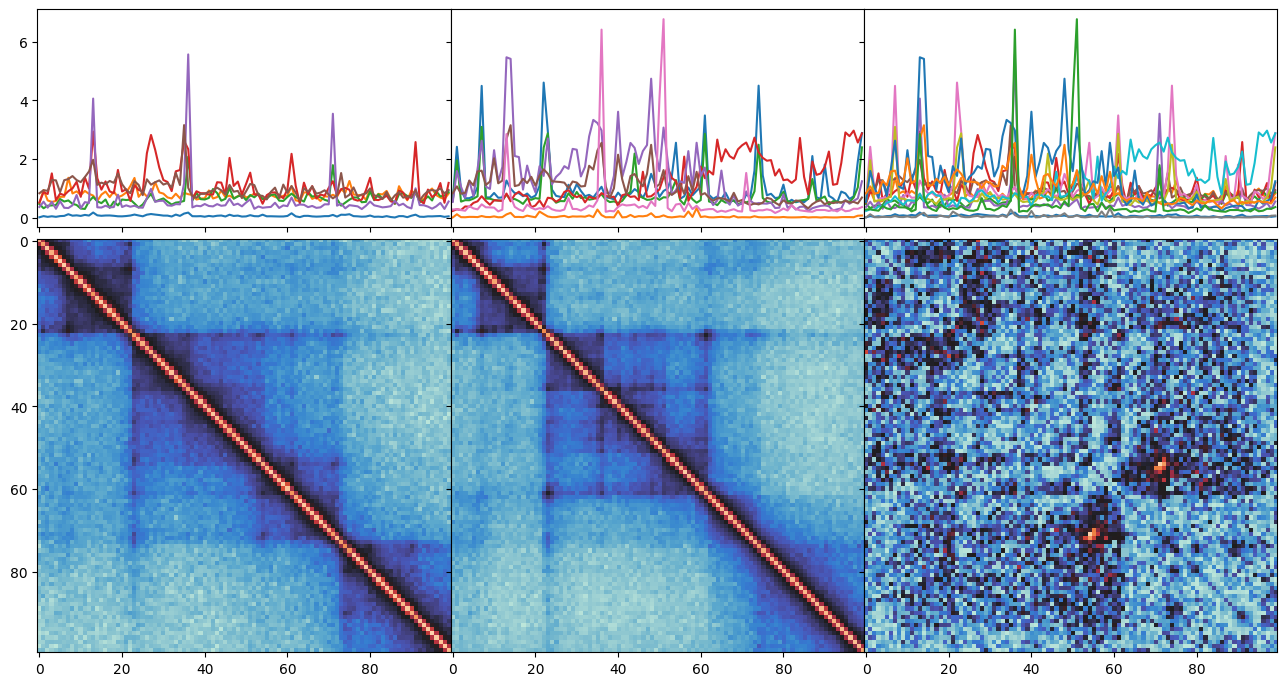

In [20]:
#fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
plot_map_diff(map_h1, map_hff, encode_h1, encode_hff, start_binned, stop_binned)

In [21]:
model = DLEM(encode_h1.shape[-1])

In [22]:
encode_tmp = torch.tensor(encode_h1[start_binned:stop_binned][np.newaxis], dtype=torch.float32)
map_tmp = torch.tensor(map_h1[start_binned:stop_binned,start_binned:stop_binned], dtype=torch.float32)

In [23]:
pred_map = model.contact_map_prediction(encode_tmp, torch.ones((1, encode_tmp.shape[1])) * encode_tmp.shape[1])

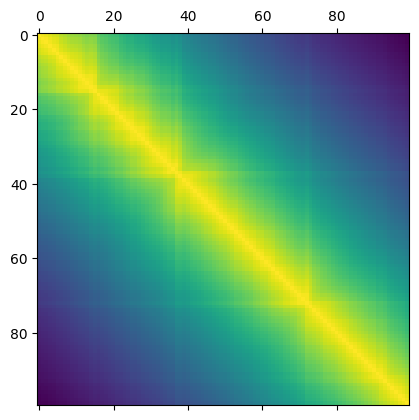

In [24]:
plt.matshow(pred_map[0])

In [25]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=125, mode="max")
diag_start = 3
diag_stop = 60

In [26]:
mat_tmp = map_tmp[np.newaxis]

In [27]:
mat_tmp.shape, encode_tmp.shape

(torch.Size([1, 100, 100]), torch.Size([1, 100, 6]))

In [28]:
best_loss_model, best_corr_model, arr_loss, arr_corr = train_w_signal(model,
                                                                      optimizer,
                                                                      scheduler,
                                                                      torch.nn.MSELoss(reduction="sum"),
                                                                      torch.exp(mat_tmp),
                                                                      encode_tmp,
                                                                      diag_start,
                                                                      diag_stop,
                                                                      dev,
                                                                      num_epoch=100)

/data/src/loopextrusion_pytorch/util.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(dev)


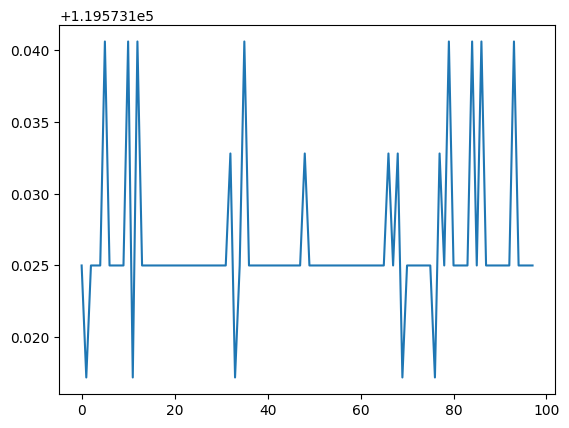

In [32]:
plt.plot(arr_loss[2:])

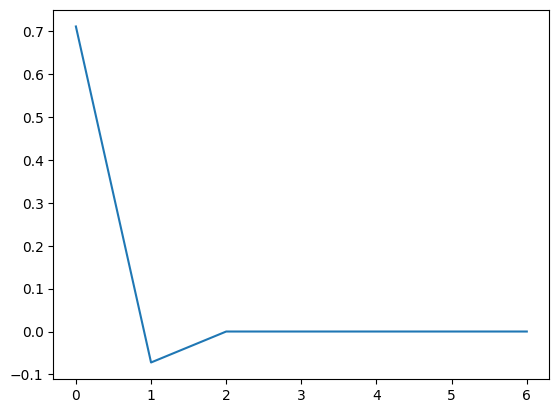

In [30]:
plt.plot(arr_corr)

In [35]:
pred_map = best_loss_model.cpu().contact_map_prediction(encode_tmp, torch.ones((1, encode_tmp.shape[1])) * encode_tmp.shape[1])

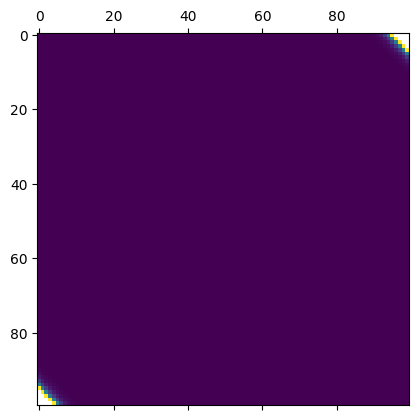

In [37]:
plt.matshow(pred_map[0])